C:\Users\alexandre\AppData\Local\Temp\ipykernel_27916\729852720.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
C:\Users\alexandre\AppData\Local\Temp\ipykernel_27916\729852720.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['ds'].dt.year
C:\Users\alexandre\AppData\Local\Temp\ipykernel_27916\729852720.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

Mean Absolute Percentage Error (MAPE): 0.02%
Root Mean Squared Error (RMSE): 1.85
Mean Absolute Error (MAE): 1.27


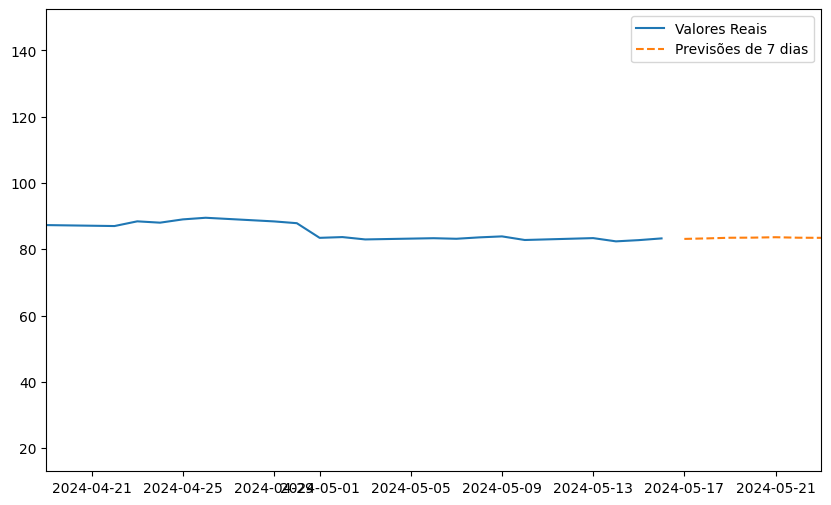

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Obter dados históricos do petróleo Brent
ticker = 'BZ=F'
df = yf.download(ticker, start='1987-01-01', end='2024-05-17', progress=False)

# Preparar os dados
df.reset_index(inplace=True)
df = df[['Date', 'Close']]
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Criar recursos adicionais (features)
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['dayofweek'] = df['ds'].dt.dayofweek

# Lag features (preços anteriores)
df['lag1'] = df['y'].shift(1)
df['lag2'] = df['y'].shift(2)
df['lag3'] = df['y'].shift(3)
df['lag7'] = df['y'].shift(7)

# Remover linhas com valores nulos (devido ao shift)
df.dropna(inplace=True)

# Dividir os dados em treino e teste
X = df[['year', 'month', 'day', 'dayofweek', 'lag1', 'lag2', 'lag3', 'lag7']]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Treinar o modelo XGBoost
model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, random_state=0)
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Calcular MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Calcular MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Função para gerar previsões para os próximos 7 dias
def forecast_next_days(model, df, days=7):
    last_row = df.iloc[-1]
    forecast_dates = pd.date_range(start=last_row['ds'], periods=days+1)[1:]
    forecast_df = pd.DataFrame({'ds': forecast_dates})
    forecast_df['year'] = forecast_df['ds'].dt.year
    forecast_df['month'] = forecast_df['ds'].dt.month
    forecast_df['day'] = forecast_df['ds'].dt.day
    forecast_df['dayofweek'] = forecast_df['ds'].dt.dayofweek

    forecasts = []
    last_values = last_row[['y', 'lag1', 'lag2', 'lag3', 'lag7']].values.flatten()

    for i in range(days):
        features = np.array([
            forecast_df.loc[i, 'year'],
            forecast_df.loc[i, 'month'],
            forecast_df.loc[i, 'day'],
            forecast_df.loc[i, 'dayofweek'],
            last_values[0],  # lag1
            last_values[1],  # lag2
            last_values[2],  # lag3
            last_values[3]   # lag7
        ]).reshape(1, -1)
        
        yhat = model.predict(features)[0]
        forecasts.append(yhat)
        
        # Atualizar lag values
        last_values = np.roll(last_values, 1)
        last_values[0] = yhat
    
    forecast_df['yhat'] = forecasts
    return forecast_df

# Gerar previsões para os próximos 7 dias com base nos últimos valores reais do dataset
forecast_df = forecast_next_days(model, df)

# Plotar os resultados, focando nos últimos 20 dias e incluindo as previsões de 7 dias
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'], label='Valores Reais')
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Previsões de 7 dias', linestyle='dashed')
plt.legend()

# Focar nos últimos 20 dias incluindo as previsões
plt.xlim(df['ds'].iloc[-20], forecast_df['ds'].iloc[-1])
plt.show()


In [3]:
import joblib
joblib.dump(model, '../Files/xgboost_model.pkl')

['../Files/xgboost_model.pkl']